In [1]:
import numpy as np
import pandas as pd
from itertools import combinations
import matplotlib.pyplot as plt
%matplotlib inline
import scipy as sc
import time
import sys

# Inputting the Data

In [10]:
# method
thresholds = np.linspace(0,.03,10)
alpha = .4
beta = 1
filesScore = ["Pij_2009.csv","Pij_2010.csv",
              "Pij_2011.csv","Pij_2012.csv",
              "Pij_2013.csv","Pij_2014.csv",
              "Pij_2015.csv","Pij_2016.csv",
              "Pij_2017.csv","Pij_2018.csv"]

filesPercs = ["2009_win_perc.csv","2010_win_perc.csv","2011_win_perc.csv","2012_win_perc.csv",
             "2013_win_perc.csv","2014_win_perc.csv","2015_win_perc.csv",
             "2016_win_perc.csv","2017_win_perc.csv","2018_win_perc.csv"]
namesCols = ["win_perc_2009","win_perc_2010","win_perc_2011","win_perc_2012",
            "win_perc_2013","win_perc_2014","win_perc_2015",
            "win_perc_2016","win_perc_2017","win_perc_2018"]

# Function that Takes the Output of the Rankings and Determines The Percent Correct

In [6]:
def ranking_analyzer_vector_output(output,names):
    # importing necessary libraries
    from itertools import combinations
    # getting vectors from the data frame
    perc1 = np.array(output[names[0]])
    perc2 = np.array(output[names[1]])
    percscore = np.array(output['score'])
    # getting the combinations
    combs = list(combinations(np.arange(32), 2))
    ncombs = len(combs)
    # initiailizing the vectors
    scorediff = np.zeros(int(ncombs))
    wins1diff = np.zeros(int(ncombs))
    wins2diff = np.zeros(int(ncombs))
    # Computing the values
    for counter, pairs in enumerate(combs):
        scorediff[counter] = percscore[pairs[0]] - percscore[pairs[1]]
        wins1diff[counter] = perc1[pairs[0]] - perc1[pairs[1]]
        wins2diff[counter] = perc2[pairs[0]] - perc2[pairs[1]] 
    
    return scorediff, wins1diff,wins2diff

In [13]:
def ranking_stats(scorediff,wins1diff,wins2diff, alpha,threshold = 0):
    # putting in a mask for plotting perspective

    threshmask = scorediff > threshold
    scoreplt = scorediff[threshmask]
    winsplt = wins2diff[threshmask]
    winsold = wins1diff[threshmask]
        
    # Getting the total combinations right
    if len(scoreplt) < 100:
        perc_correct_score = 0
        perc_correct_wins = 0
    else:
        perc_correct_score = sum(winsplt>0)/len(scoreplt)
        perc_correct_wins = (sum(np.logical_and(winsold>0,winsplt>0))+ \
                             sum(np.logical_and(winsold<0,winsplt<0)))/len(winsplt)
        
    return perc_correct_score,perc_correct_wins
    

# Function to Take A Pij Matrix and Apply Bagging

We want this function to take as an inputs:

- $P_{ij}$, the original stochastic matrix.
- $\alpha$, the teleportation paramter
- $stats1$, a vector containing the winning percentages of the teams of interest
- $namesCols$, the names of the win percentage vectors
- $N$, the number of teams to eliminate at each step (anticipate 1 or 2 will be best)
- $method$, the method for determining $\nu$, set to 0 (for using weights in each node) by default if not specified.


We want this function to output:

- $S$, a matrix of scores where each row is one of the 32 teams, and each column is that teams computed score when ommiting a combination of teams

In [4]:
def score_bagging(Pij, stats1, namesCols, alpha, N, Nsims = 2500, method = 0):
    # setting a vector to contain each of the 32 team numbers
    teamnum = np.arange(32)
    # Getting the possible combinations of this to use
    combs = list(combinations(teamnum, N))
    ncombs = len(combs)
    # initializing a matrix to store each of these values
    scores = np.zeros((len(teamnum),ncombs))
    # We iterate over all of these combinations, each time computing a final score vector
    for counter, group in enumerate(combs):
        # Adjusting Pij (first deleting the specified rows, then columns)
        Pij_group = np.delete(Pij,group,axis = 0)
        Pij_group = np.delete(Pij_group,group,axis = 1)
        
        # Ensuring Pij has no zero columns
        if len(np.where(Pij_group.sum(axis = 0) == 0)[0]) > 0:
                empty_vect = np.where(Pij_group.sum(axis = 0) == 0)[0]
                for iCnt in range(len(empty_vect)):
                    Pij_group[empty_vect[iCnt],empty_vect[iCnt]] = 1
        
        # -----------Getting the Scores (FROM PREVIOUS CODE)------------------------
        # If we want the teleportation probabilties unifrom,
        # or based on team winning perc
        if method == 0:
            # making the teleporting probabilities uniform
            v = np.ones(len(teamnum)-N)/(len(teamnum)-N)
            v = v[np.newaxis]
            v = v.T
            # Setting alpha
            alpha = alpha
            # Setting eT
            eT = np.ones(len(teamnum)-N)[np.newaxis]   
        else:
            # making the teleporting probabilities proportional to
            # the teams winning percentages
            v = np.array(stats1[namesCols])
            v = np.delete(v, group)
            v = v[np.newaxis]
            v = v.T
            v = v/np.sum(v)
            # Setting alpha
            alpha = alpha
            # Setting eT
            eT = np.ones(len(teamnum)-N)[np.newaxis]
                
        # initializing our first guess
        x0 = np.ones(len(teamnum)-N)/len(teamnum)-N
        x0 = x0[np.newaxis]
        x0 = x0.T
            
        # performing the simulation (so our scores are stored in x0)
        for i in range(Nsims):
            x0 = alpha*np.dot(Pij_group,x0) + (1-alpha)*v

        # ---------------------- (END OF PREVIOUS CODE) ------------------------
        # getting a vector of the values of the teams computed
        kept_vect = np.delete(teamnum,group)
        # Updating the matrix
        scores[kept_vect,counter] = np.squeeze(x0)
    return scores    

# Function to take the Score Matrix as an Input and Output the Final PageRank Vector

This function takes as inputs:

- $S$, a matrix of scores where each row is one of the 32 teams, and each column is that teams computed score when ommiting a combination of teams
- $\bar{x}$, the PageRank vector computed for each team over __full__ data set.
- $\beta$, where the PageRank for each team is computed to be $x_i = (1-\beta)\bar{x}_i + \beta\big(min\{S_{ik}, 1 \leq k \leq {32 \choose N} \text{ for } k \in Z \}\big)$ where $N$ is the number of games removed at a time from the "score_bagging" function.

This function outputs:

- $x$, the vector containing the final PageRank scores for each team.

In [5]:
def final_score(S, x_bar, beta):
    # getting the minimum vector
    min_vect = np.zeros(32)
    # computing the minimums
    for iCnt in range(len(min_vect)):
        # accounting for winless teams
        if len(S[iCnt,np.nonzero(S[iCnt,])[0]]) == 0:
            min_vect[iCnt] = 0
        else:
            min_vect[iCnt] =  np.min(S[iCnt,np.nonzero(S[iCnt,])[0]])
    # normalizing the minimum vector
    min_vect = min_vect/np.sum(min_vect)
    # computing x
    x = (1-beta)*x_bar + beta*min_vect
    # normalizing x
    x = x/np.sum(x)
    # returning the value
    return np.squeeze(x)

# Writing a Function to Take Beta As a Parameter and Compute the Percent of Correct Combinations

This function has the following inputs:

- $\beta$, where the PageRank for each team is computed to be $x_i = (1-\beta)\bar{x}_i + \beta\big(min\{S_{ik}, 1 \leq k \leq {32 \choose N} \text{ for } k \in Z \}\big)$ where $N$ is the number of games removed at a time from the "score_bagging" function.
- $\alpha$, the teleportation parameter
- $method$, the method for determining $\nu$, set to 0 (for using weights in each node) by default if not specified.
- $filesScore$, vector of filenames containing the socres in proper matrix form
- $filesPercs$, a vector of filenames containing the winning percentages of each team in a given year (used for $\nu$ non-uniform)
- $namesCols$, the names of the win percentage vectors
- $N$, the number of teams to omit on each iteration
- $nSims$, the number of terms to include in the approximation of the true eigenvector
- $weighted$, a boolean value that is true if the nodes of the graph are to be weighted, and false if they are to be binary.

This function has the following outputs:

- __score_perc_total__, the percentage of combinations of teams correctly predicted by the bagged PageRank method
- __score_perc_S2__, the standard error of the percentage of combinations of teams correctly predicted by the bagged PageRank method
- __wins_perc_total__, the percentage of combinations of teams correctly predicted by the standings in the current year
- __wins_perc_S2__, the standard error of the percentage of combinations of teams correctly predicted by the standings in the current year

In [8]:
def thresh_optimize_perc_combs2(thresholds,alpha,method,filesScore,filesPercs,namesCols, beta = 1,N = 1, nSims = 5000,weighted = True):
    # intializing two vectors to store results
    score_perc_total = np.zeros(len(thresholds))
    score_perc_S2 = np.zeros(len(thresholds))
    wins_perc_total = np.zeros(len(thresholds))
    wins_perc_S2 = np.zeros(len(thresholds))

    indexer = 0
    
    if(alpha >= .8):
        nSims_use = nSims
    else:
        nSims_use = 5000
    
    # Generating the scores matrix for each year
    # setting a vector to contain each of the 32 team numbers
    teamnum = np.arange(32)
    # Getting the possible combinations of this to use
    combs = list(combinations(teamnum, N))
    ncombs = len(combs)
    scores_mat_for_all = np.zeros((len(filesScore) - 1,32,ncombs))
    
    # iterating over all years (we lose a year since we don't have anything 
    # to regress the 2019 data on)
    
    # making a waitbar
    toolbar_width = len(filesScore) - 1
    sys.stdout.write("[%s]" % (" " * toolbar_width))
    sys.stdout.flush()
    sys.stdout.write("\b" * (toolbar_width+1))
    
    for year_of_data in np.arange(len(filesScore) - 1):
            
        # reading in the data
        data = pd.read_csv(filesScore[year_of_data],index_col=0)
        stats1 = pd.read_csv(filesPercs[year_of_data],index_col=0)
        stats2 = pd.read_csv(filesPercs[year_of_data + 1],index_col=0)
        # converting to a numpy array
        data2 = np.array(data)
            
        if(weighted == False):
            data2[data2!=0] = 1
            
        # making the Pij matrix
        Pij = data2/data2.sum(axis=0)
              
        # ---------------------- NEW PART OF FUNCTION (getting scores) ---------------
            
        scores_mat_for_all[year_of_data] = score_bagging(Pij, stats1, namesCols[year_of_data], \
                                       alpha, N, Nsims = nSims_use, method = method)
        
        sys.stdout.write("-")
        sys.stdout.flush()
        
    sys.stdout.write("\n")    
    # ----------------------- ITERATING OVER BETA ------------
    
    # making a waitbar
    toolbar_width = len(thresholds)
    sys.stdout.write("[%s]" % (" " * toolbar_width))
    sys.stdout.flush()
    sys.stdout.write("\b" * (toolbar_width+1))

    
    for threshold_try in thresholds:
        
        # initializing the two correlations
        mc_perc_score = 0
        mc_perc_wins = 0
        
        # intializing a vector to get each percentage (for getting a standard deviation)
        sd_vect = np.zeros(len(filesScore) - 1)
        sd_vect_wins = np.zeros(len(filesScore) - 1)
        
        # iterating over all years (we lose a year since we don't have anything 
        # to regress the 2019 data on)
        for year_of_data in np.arange(len(filesScore) - 1):
            
            # reading in the data
            data = pd.read_csv(filesScore[year_of_data],index_col=0)
            stats1 = pd.read_csv(filesPercs[year_of_data],index_col=0)
            stats2 = pd.read_csv(filesPercs[year_of_data + 1],index_col=0)
            
            # converting to a numpy array
            data2 = np.array(data)
            
            if(weighted == False):
                data2[data2!=0] = 1
            
            # making the Pij matrix
            Pij = data2/data2.sum(axis=0)
            
            # If we want the teleportation probabilties unifrom,
            # or based on team winning perc
            if method == 0:
                # making the teleporting probabilities uniform
                v = np.ones(32)/32
                v = v[np.newaxis]
                v = v.T
                # Setting eT
                eT = np.ones(32)[np.newaxis]   
            else:
                # making the teleporting probabilities proportional to
                # the teams winning percentages
                v = np.array(stats1[namesCols[year_of_data]])
                v = v[np.newaxis]
                v = v.T
                v = v/np.sum(v)
                # Setting eT
                eT = np.ones(32)[np.newaxis]
                
            # initializing our first guess
            x0 = np.ones(32)/32
            x0 = x0[np.newaxis]
            x0 = x0.T
            
            # performing the simulation
            for i in range(nSims_use):
                x0 = alpha*np.dot(Pij,x0) + (1-alpha)*v
            
            x0 = np.squeeze(x0)
            
            # ----------------------------- COMPUTING xf ----------------------------------
            
            xf = final_score(scores_mat_for_all[year_of_data], x0, beta)
            
            # -------------------------------------------------------------------------------

            # defining the team names
            team_names = np.array(data.columns.get_values())
            
            # ordering the team's by their score
            mask = np.argsort(np.squeeze(xf))[::-1]
            xf_df = np.squeeze(xf[mask])
            team_names_df = team_names[mask]
            
            # forming a data frame
            teamrank = {'Team': team_names_df, 'score': xf_df, 'wins': 32*16/2*xf_df}
            teamrank_df = pd.DataFrame(data=teamrank)
            
            output = pd.merge(teamrank_df,
                  stats1,
                  left_on = "Team",
                  right_on = "team",
                  how = "inner")

            output = pd.merge(output,
                  stats2,
                  left_on = "Team",
                  right_on = "team",
                  how = "inner")
            
            # Figuring out ranks
            names = [namesCols[year_of_data],namesCols[year_of_data+1]]
            scorediff, wins1diff,wins2diff = ranking_analyzer_vector_output(output,names)
            ps,pw = ranking_stats(scorediff,wins1diff,wins2diff,alpha,threshold = threshold_try)
            
            # Storing the results
            mc_perc_score += ps
            sd_vect[year_of_data] = ps
            mc_perc_wins += pw
            sd_vect_wins[year_of_data] = pw
            
            
            
        # Updating the percentages
        score_perc_total[indexer] = mc_perc_score/(len(filesScore) - 1)
        score_perc_S2[indexer] = np.std(sd_vect)/np.sqrt(len(filesScore) - 1)
        wins_perc_total[indexer] = mc_perc_wins/(len(filesScore) - 1)
        wins_perc_S2[indexer] = np.std(sd_vect_wins)/np.sqrt(len(filesScore) - 1)
        indexer += 1
        sys.stdout.write("-")
        sys.stdout.flush()
    
        
    sys.stdout.write("\n")
    return score_perc_total,score_perc_S2,wins_perc_total,wins_perc_S2

# Running it For $\alpha = 0.4$

In [30]:
alpha = 0.4
thresholds = np.linspace(0,0.0155,20)

In [ ]:
ps1, pss1, pw1, pws1 = thresh_optimize_perc_combs2(thresholds,alpha, \
                            0,filesScore,filesPercs,namesCols, beta = 1,N = 1)

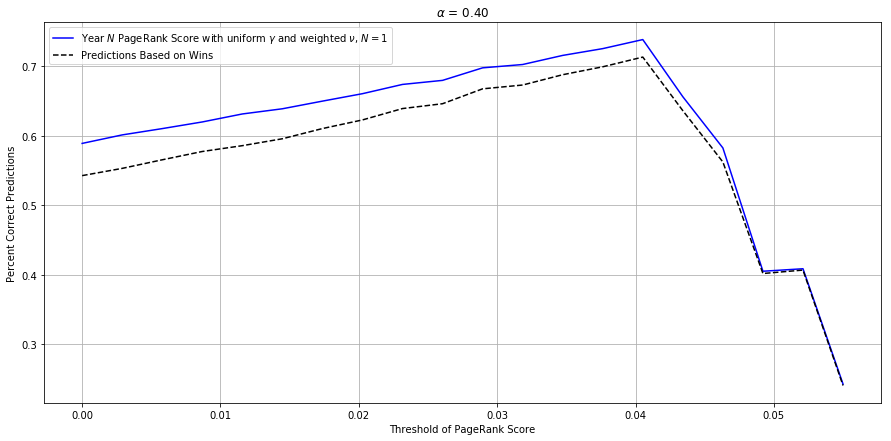

In [29]:
plt.figure(figsize=(15,7))
plt.plot(threshold,ps1,'b-',label = r'Year $N$ PageRank Score with uniform $\gamma$ and weighted $\nu$, $N = 1$')
plt.plot(threshold,pw1,'k--',label = r'Predictions Based on Wins')
plt.grid()
plt.xlabel("Threshold of PageRank Score")
plt.ylabel("Percent Correct Predictions")
plt.legend()
plt.title(r'$\alpha$ = %.2f' %alpha)
plt.show()

In [31]:
ps2, pss2, pw2, pws2 = thresh_optimize_perc_combs2(thresholds,alpha, \
                            0,filesScore,filesPercs,namesCols, beta = 1,N = 1, weighted = False)

[        ---------
[                    --------------------


In [33]:
ps3, pss3, pw3, pws3 = thresh_optimize_perc_combs2(thresholds,alpha, \
                            1,filesScore,filesPercs,namesCols, beta = 1,N = 1)

[        ---------
[                    --------------------


In [35]:
ps4, pss4, pw4, pws4 = thresh_optimize_perc_combs2(thresholds,alpha, \
                            1,filesScore,filesPercs,namesCols, beta = 1,N = 1, weighted = False)

[        ---------
[                    --------------------


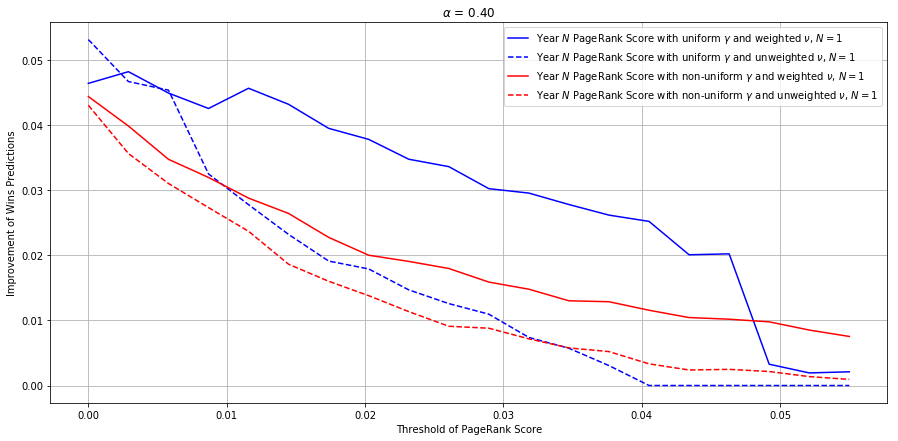

In [37]:
plt.figure(figsize=(15,7))
plt.plot(threshold,ps1 - pw1,'b-',label = r'Year $N$ PageRank Score with uniform $\gamma$ and weighted $\nu$, $N = 1$')
plt.plot(threshold,ps2 - pw2,'b--',label = r'Year $N$ PageRank Score with uniform $\gamma$ and unweighted $\nu$, $N = 1$')
plt.plot(threshold,ps3 - pw3,'r-',label = r'Year $N$ PageRank Score with non-uniform $\gamma$ and weighted $\nu$, $N = 1$')
plt.plot(threshold,ps4 - pw4,'r--',label = r'Year $N$ PageRank Score with non-uniform $\gamma$ and unweighted $\nu$, $N = 1$')
plt.grid()
plt.xlabel("Threshold of PageRank Score")
plt.ylabel("Improvement of Wins Predictions")
plt.legend()
plt.title(r'$\alpha$ = %.2f' %alpha)
plt.show()